faça um código que o produto final, você deve entregar:

- um arquivo csv no qual as linhas já estarão ordenas de acordo com a rota a ser seguida. Além disso, os dados devem estar no padrão especificado abaixo e contendo as seguintes colunas: id da escola, nome da escola, tipo da escola (EM, CIEP ou colégio), logradouro da entrega, número, bairro, subprefeitura, latitude, longitude e quantidade de mat erial didático que deve ser entregue. O logradouro da escola deve estar em uma coluna diferente do número;

- um arquivo csv com a quantidade total de material escolar por subprefeitura para que sejam contabilizados os custos por subprefeitura


- Como padrão dos dados, considere:

*nome das colunas em snake_case
*strings não devem conter acentos
*todas as strings devem estar em maiúsculo
*padronização do nome dos logradouros sem abreviação (Ex: R. deve estar como Rua, Av. deve estar como avenida)
*latitude e longitude devem conter apenas 5 casas decimais
*os ids da escola devem todos ser strings com 3 caracteres (Ex: '024')

etapa 1: Carregar os Dados


In [15]:
#importei todas as bibliotecas necessárias
import pandas as pd
import numpy as np
import math
import re

# Carreguei os dados das escolas, subprefeituras e quantidade de material didático

escolas_df = pd.read_csv('escolas.csv', encoding='utf-8')

subprefeituras_df = pd.read_csv('subprefeituras.csv', encoding='utf-8')

material_didatico_df = pd.read_csv('material_didatico.csv', encoding='utf-8')


In [16]:
#CODIGO FORNECIDO PELO PROFESSOR
def distance(point1, point2):
    
    #Calcula a distância entre dois pontos geográficos, usando a fórmula de Haversine.
    
    lat1, lon1 = point1
    lat2, lon2 = point2
    R = 6371  # raio da Terra em quilômetros
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = (
        math.sin(delta_phi / 2) ** 2
        + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    )
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    d = R * c
    return d


def nearest_neighbor(points):
    unvisited = set(
        range(1, len(points))
    )  # índices que representam os pontos não visitados
    current_point = 0
    route = [current_point]

    while unvisited:
        nearest = min(
            unvisited, key=lambda x: distance(points[current_point], points[x])
        )
        route.append(nearest)
        unvisited.remove(nearest)
        current_point = nearest

    route.append(0)  # Volta ao ponto inicial para fechar o ciclo
    return route


Etapa 2: Padronização dos Dados - Pré-processamento dos Dados

  - Nesta etapa, fizemos o pré-processamento dos dados dos arquivos CSV para atender aos padrões especificados.

In [17]:
# Padronizei o nome das colunas em snake_case(mesmo sabendo que subprefeituras e material didático não precisa, quis colocar assim mesmo)
escolas_df.columns = escolas_df.columns.str.strip().str.lower().str.replace(' ', '_')
subprefeituras_df.columns = subprefeituras_df.columns.str.strip().str.lower().str.replace(' ','_')
material_didatico_df.columns = material_didatico_df.columns.str.strip().str.lower().str.replace(' ','_')

# Converti a coluna 'id' para string no DataFrame 'material_didatico_df'
material_didatico_df['id'] = material_didatico_df['id'].astype(str)

# Removi os acentos e coloquei em maiúsculo
escolas_df['bairro'] = escolas_df['bairro'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace('ç', 'c').str.upper()
escolas_df['endereço'] = escolas_df['endereço'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace('ç', 'c').str.upper()
escolas_df['id'] = escolas_df['id'].astype(str).str.zfill(3).str.upper()  

subprefeituras_df['nome'] = subprefeituras_df['nome'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace('ç', 'c').str.upper()
subprefeituras_df['subprefeitura'] = subprefeituras_df['subprefeitura'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace('ç', 'c').str.upper()

# 1. Remover vírgulas e converter as colunas 'latitude' e 'longitude' em números de ponto flutuante
escolas_df['lat'] = escolas_df['lat'].str.replace(',', '.')
escolas_df['lon'] = escolas_df['lon'].str.replace(',', '.')

# Padronizar os nomes das escolas
escolas_df['escolas_postos'] = escolas_df['escolas_postos'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace('Ç', 'C').str.replace('CIEP', 'CENTRO INTEGRADO DE EDUCACAO PUBLICA').str.replace('.', '').str.replace('EM', 'ESCOLA MUNICIPAL').str.upper()

#criar função para remover 'colegio municipal', 'escola municipal' e 'CIEP' criando uma nova coluna chamada 'TIPO_DA_ESCOLA'

def extrair_tipo_escola(escolas_postos):
    # Use expressões regulares para encontrar os tipos na string
    tipos = ['ESCOLA MUNICIPAL', 'CENTRO INTEGRADO DE EDUCACAO PUBLICA', 'COLEGIO MUNICIPAL']
    
    for tipo in tipos:
        busca_tipo = re.search(tipo, escolas_postos)
        if busca_tipo:
            tipo_encontrado = busca_tipo.group()
            # Remova o tipo da coluna original "escolas_postos"
            novo_escolas_postos = escolas_postos.replace(tipo_encontrado, '').strip()
            return tipo_encontrado, novo_escolas_postos
    
    # Se nenhum tipo de escola for encontrado, retorne None
    return None

# Padronizar o nome e número dos logradouros
escolas_df['endereço'] = escolas_df['endereço'].str.replace('R.', 'RUA').str.replace('AV.', 'AVENIDA').str.replace('S/Nº', '').str.replace('S/N', '').str.replace(',', '')


def extrair_numero_logradouro(endereço):
    # Usei uma expressão regular para encontrar o número na string
    busca_numero = re.search(r'\d+$', endereço)
    if busca_numero:
        numero = busca_numero.group()
        # Remova o número da coluna original "endereço"
        novo_endereco = endereço.replace(numero, '').strip()
        return numero, novo_endereco
    else:
        return 'S/N', endereço




Etapa 3: Combinar Dados e Selecionar Colunas

In [18]:

# Aplicar a função para criar uma nova coluna 'numero' e ajustar a coluna 'endereço'
escolas_df['numero'], escolas_df['endereço'] = zip(*escolas_df['endereço'].apply(extrair_numero_logradouro))

# Aplicar a função para criar uma nova coluna 'tipo' e ajustar a coluna 'escoals_postos'
escolas_df['tipo'], escolas_df['escolas_postos'] = zip(*escolas_df['escolas_postos'].apply(extrair_tipo_escola))

# Renomear coluna 'nome' para evitar conflito
subprefeituras_df = subprefeituras_df.rename(columns={'nome': 'nome_subprefeitura'})

# Juntar dados da quantidade de material didático
escolas_df = escolas_df.merge(material_didatico_df, on='id', how='left')

# Juntar dados das subprefeituras
escolas_df = escolas_df.merge(subprefeituras_df, left_on='bairro', right_on='nome_subprefeitura', how='left')

# Selecionar as colunas necessárias
colunas_selecionadas = ['id','tipo', 'escolas_postos', 'bairro', 'endereço', 'numero', 'nome_subprefeitura', 'quantidade', 'lat', 'lon']
escolas_df = escolas_df[colunas_selecionadas]

# Renomear as colunas
escolas_df = escolas_df.rename(columns={'id': 'id_da_escola','tipo':'tipo_da_escola', 'escolas_postos': 'nome_da_escola',
                                        'endereço': 'logradouro_da_entrega', 'quantidade': 'quantidade_de_material_didatico', 'lat': 'latitude', 'lon': 'longitude'})

# Formatar os dados
# Preencher valores NaN com zero
escolas_df['quantidade_de_material_didatico'] = escolas_df['quantidade_de_material_didatico'].fillna('0')

# Converter para inteiros
escolas_df['quantidade_de_material_didatico'] = escolas_df['quantidade_de_material_didatico'].apply(lambda x: int(x) if x.isdigit() else 0)



# Exportar o DataFrame reorganizado para um arquivo CSV
escolas_df.to_csv('escolas_ordenadas.csv', index=False, encoding='utf-8')

# Mensagem de conclusão
print("Etapa 3 concluída: Dados das escolas reorganizados e exportados para 'escolas_ordenadas.csv'.")


Etapa 3 concluída: Dados das escolas reorganizados e exportados para 'escolas_ordenadas.csv'.


Etapa 4: Ordenar as Escolas e salvar resultados

In [19]:


# Etapa 4: Ordenar as Escolas com Base na Rota Otimizada

# 1. converter as colunas 'latitude' e 'longitude' em números de ponto flutuante
escolas_df['latitude'] = escolas_df['latitude'].astype(float)
escolas_df['longitude'] = escolas_df['longitude'].astype(float)




# Exemplo de lista de pontos (latitude, longitude)
# pontos_entrega = [(lat1, lon1), (lat2, lon2), ...]  # Substitua pelos seus pontos
escolas_df.reset_index(inplace=True,drop=True)
pontos_entrega = list(zip(escolas_df['latitude'], escolas_df['longitude']))

best_route = nearest_neighbor(pontos_entrega)
#best_route.pop()

print("Melhor rota:", best_route)


Melhor rota: [0, 1, 8, 3, 30, 31, 22, 29, 28, 27, 23, 26, 43, 45, 51, 47, 52, 68, 66, 63, 67, 65, 61, 55, 62, 58, 59, 64, 54, 81, 83, 49, 60, 53, 70, 73, 78, 90, 87, 79, 86, 69, 80, 135, 143, 151, 88, 99, 89, 111, 77, 75, 76, 74, 108, 85, 109, 115, 118, 119, 98, 102, 101, 91, 92, 100, 97, 103, 94, 33, 32, 35, 16, 5, 20, 14, 13, 18, 12, 21, 11, 2, 6, 7, 24, 9, 25, 57, 84, 4, 19, 17, 10, 39, 41, 34, 40, 46, 48, 50, 36, 44, 38, 37, 42, 82, 72, 71, 15, 110, 114, 113, 116, 106, 107, 104, 105, 127, 122, 130, 120, 121, 129, 56, 112, 123, 124, 128, 125, 136, 141, 131, 133, 138, 134, 142, 137, 145, 144, 147, 146, 150, 148, 126, 96, 93, 149, 95, 140, 132, 139, 117, 0]


Etapa 5: Salvar Resultados

In [20]:


#Reorganizar o DataFrame com base na rota otimizada
escolas_ordenadas_df = escolas_df.reindex(best_route)

# Exportar o DataFrame reorganizado para um arquivo CSV
escolas_ordenadas_df.to_csv('resultados_otimizados.csv', index=False, encoding='utf-8')

# Mensagem de conclusão
print("Etapa 5 concluída: Escolas reorganizadas e exportadas para 'resultados_otimizados.csv'.")

Etapa 5 concluída: Escolas reorganizadas e exportadas para 'resultados_otimizados.csv'.


DESAFIO:

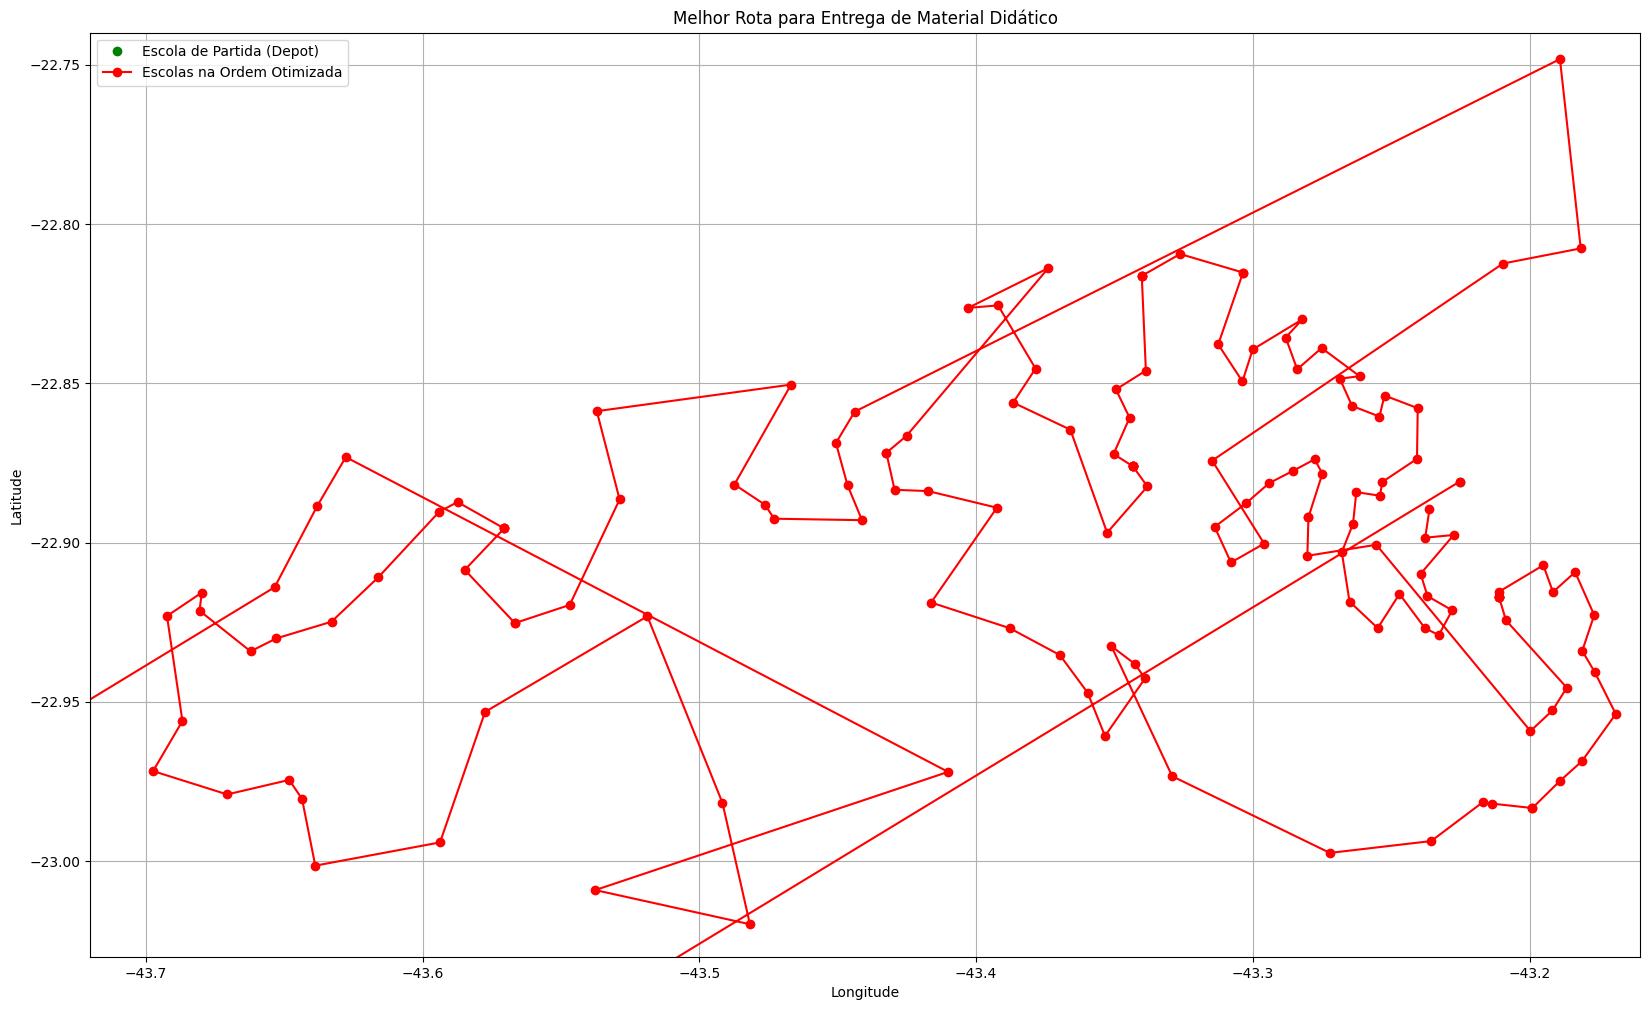

In [21]:

import matplotlib.pyplot as plt

# Coordenadas das escolas na ordem otimizada
coords_otimizadas = escolas_ordenadas_df[['latitude', 'longitude']].values

# Coordenadas da escola de partida (depot)
coord_depot = coords_otimizadas[0]


# Plot das coordenadas das escolas
plt.figure(figsize=(20, 12))
plt.plot(coord_depot[1], coord_depot[0], 'go', label='Escola de Partida (Depot)')
plt.plot(coords_otimizadas[1:, 1], coords_otimizadas[1:, 0], 'ro-', label='Escolas na Ordem Otimizada')

# Configurações do gráfico
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Melhor Rota para Entrega de Material Didático')
plt.legend()
plt.grid()
plt.xlim(-43.72, -43.16)  # Define os limites do eixo x
plt.ylim(-23.03, -22.74)  # Define os limites do eixo y

# Exibir o gráfico
plt.show()
